In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
hawaii_cxn = engine.connect()
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)


C:\Users\qwert\AppData\Local\Temp\ipykernel_2472\3055022161.py:7: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
classes = Base.classes.keys()
classes

['station', 'measurement']

In [7]:
# Save references to each table
measurement_table = Base.classes.measurement
station_table = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(measurement_table.date)).scalar()
recent_date

'2017-08-23'

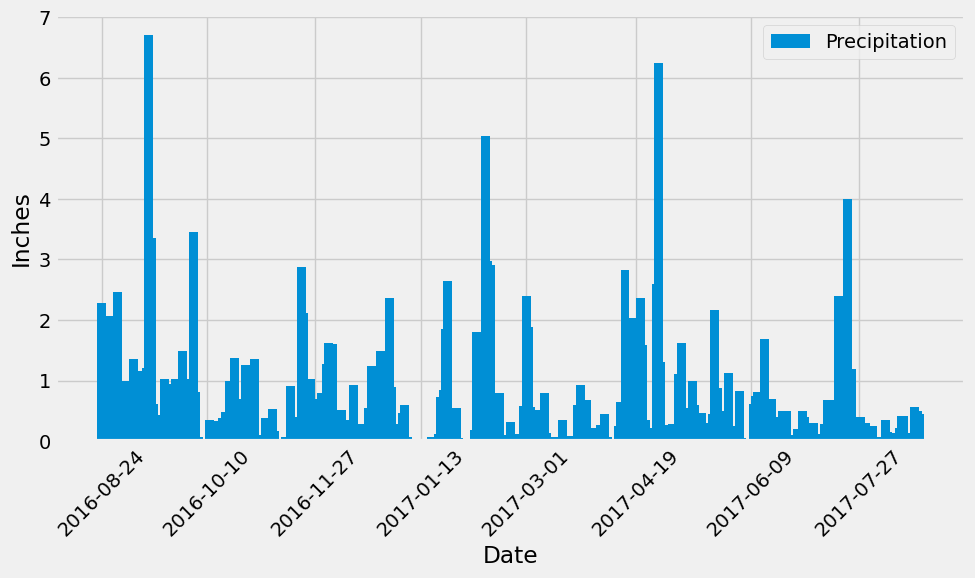

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
recent_date_convert = dt.datetime(*map(int, recent_date.split('-')))
one_year_previous = (recent_date_convert - dt.timedelta(days=365))
precipitation_data = session.query(measurement_table.date, measurement_table.prcp).filter(measurement_table.date >= one_year_previous).order_by(measurement_table.date).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names

prcp_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
prcp_df.set_index('Date', inplace=True)
prcp_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(prcp_df.index, prcp_df['Precipitation'], width=4, label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.xticks(prcp_df.index[::300])
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(func.count(station_table.station)).scalar()
stations_count

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement_table.station, func.count(measurement_table.station))\
.group_by(measurement_table.station)\
.order_by(func.count(measurement_table.station).desc()).all()

active_stations 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(
    func.min(measurement_table.tobs),
    func.max(measurement_table.tobs),
    func.avg(measurement_table.tobs)).filter(measurement_table.station == most_active_station).all()
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

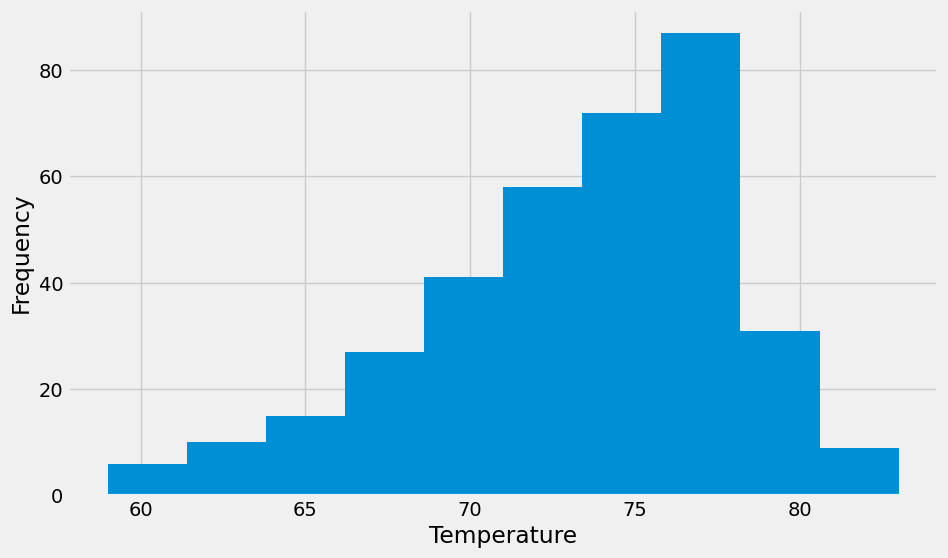

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_recent_date = session.query(func.max(measurement_table.date)).filter(measurement_table.station == most_active_station).scalar()
station_recent_date_convert = dt.datetime(*map(int, station_recent_date.split('-')))
station_one_year_previous = (station_recent_date_convert - dt.timedelta(days=365))
station_data = session.query(measurement_table.date, measurement_table.tobs)\
.filter(measurement_table.date >= station_one_year_previous)\
.filter(measurement_table.station == most_active_station)\
.order_by(measurement_table.date).all()
station_data_df = pd.DataFrame(station_data, columns=['Date', 'Temperatures'])
station_data_df.set_index('Date', inplace=True)
station_data_df.sort_index(inplace=True)
plt.figure(figsize=(10, 6))
plt.hist(station_data_df['Temperatures'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()